In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from zipfile import ZipFile
import shutil
import os
import tqdm
import scipy
import glob
import matplotlib.pyplot as plt
import scipy.spatial
import copy
import pydegensac
import gc
import collections
import operator

import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

tf.config.set_visible_devices([], 'GPU')

import sys
sys.path.append('../')

import config
import generator
import models
import serve



In [2]:
def read_train_file(input_path, alpha=0.5):
    files_paths = glob.glob(input_path + 'train/*/*/*/*')
    mapping = {}
    for path in files_paths:
        mapping[path.split('/')[-1].split('.')[0]] = path
    df = pd.read_csv(input_path + 'train.csv')
    df['path'] = df['id'].map(mapping)
    counts_map = dict(
        df.groupby('landmark_id')['path'].agg(lambda x: len(x)))
    counts = df['landmark_id'].map(counts_map)
    df['prob'] = ((1/np.sqrt(counts)) / (1/np.sqrt(counts)).max()).astype(np.float32)
    uniques = df['landmark_id'].unique()
    df['label'] = df['landmark_id'].map(dict(zip(uniques, range(len(uniques)))))
    return df

data = read_train_file('../input/')

In [3]:
def read_train_file(input_path, alpha=0.5):
    files_paths = glob.glob(input_path + 'test/*/*/*/*')
    mapping = {}
    for path in files_paths:
        mapping[path.split('/')[-1].split('.')[0]] = path
    df = pd.read_csv(input_path + 'sample_submission.csv')
    df['path'] = df['id'].map(mapping)
    return df

train_df = read_train_file('../input/')

In [4]:
imported = tf.saved_model.load('../output/served_models/model')

In [5]:
DIM = 512
ATTENTION_THRESHOLD = 500.0

In [6]:
def extract_local_descriptor(model, 
                             path, 
                             image_id,
                             dim,
                             reverse,
                             use_rf_boxes,
                             attention_threshold,
                             max_num_features):
    
    image = model.extract_image(
        path=path,
        image_id=image_id,
        dim=dim, 
        central_crop=True, 
        crop_ratio=(0.7, 1.0))
    
    if reverse:
        image = tf.reverse(image, [2])
#     image_path = (
#             path + '/' +
#             tf.strings.substr(image_id, 0, 1) + '/' +
#             tf.strings.substr(image_id, 1, 1) + '/' +
#             tf.strings.substr(image_id, 2, 1) + '/' +
#             image_id + '.jpg'
#         )
#     image = tf.io.read_file(image_path)
#     image = tf.io.decode_jpeg(image)
#     shape = tf.shape(image)[:2]
#     h, w = shape
    
#     if h > w:
#         h = dim
#         w = (w/h)*dim
#     elif w > h:
#         w = dim
#         h = (h/w)*dim
#     else:
#         w = dim
#         h= dim
    
#     image = tf.image.resize(image, (h, w), method='area', preserve_aspect_ratio=True)
#     image = image[tf.newaxis]
#     image = image /  255.
    
    
    local_descriptor, keypoints = model.extract_local_descriptor(
        image=image, 
        l2_norm=True, 
        use_rf_boxes=use_rf_boxes,
        attention_threshold=attention_threshold,
        max_num_features=max_num_features)

    image = tf.cast(image[0] * 255, tf.uint8)
    return image, local_descriptor, keypoints
    

def compute_matching_keypoints(x1, x2, max_distance):
    
    '''
    Finds matches from 'test_descriptors' to the KD-tree of 'train_descriptors'. 
    Functions as a fast nearest neighbour search.
    
    '''
    
    x1_tree = scipy.spatial.cKDTree(x1[0])
    _, matches = x1_tree.query(x2[0], distance_upper_bound=max_distance)
    
    x1_kp_count = x1[1].shape[0]
    x2_kp_count = x2[1].shape[0]
    
    x2_matching_keypoints = np.array([
        x2[1][i,]
        for i in range(x2_kp_count)
        if matches[i] != x1_kp_count
    ])

    x1_matching_keypoints = np.array([
        x1[1][matches[i],]
        for i in range(x2_kp_count)
        if matches[i] != x1_kp_count
    ])
    
    return x1_matching_keypoints, x2_matching_keypoints
    
def compute_num_inliers(x1, 
                        x2,
                        max_reprojection_error=10.0,
                        homography_confidence=0.99,
                        max_ransac_iterations=1000):
    
    '''
    Out of the matches descriptor keypoints, runs a RANSAC to computes the
    number of inliers.
    '''
    x1_matching_keypoints, x2_matching_keypoints = compute_matching_keypoints(
        x1, x2, max_distance=0.9)
    # Min keypoints supported by `pydegensac.findHomography()`
    if x2_matching_keypoints.shape[0] < 1:  
        return 0, 0, 0, 0
    elif x2_matching_keypoints.shape[0] <= 4:  
        return -1, -1, -1, -1

    try:
        _, mask = pydegensac.findHomography(
            x2_matching_keypoints, x1_matching_keypoints, 
            max_reprojection_error,
            homography_confidence, 
            max_ransac_iterations
        )
    except np.linalg.LinAlgError:  # When det(H)=0, can't invert matrix.
        return 0, 0, 0, 0
    
    return x1_matching_keypoints, x2_matching_keypoints, copy.deepcopy(mask), copy.deepcopy(mask).sum()

pred  = 0
conf  = 0.9999864
num points A = 232 ; num matches A= 1
num points B = 124 ; num matches B= 1
final matches = -1


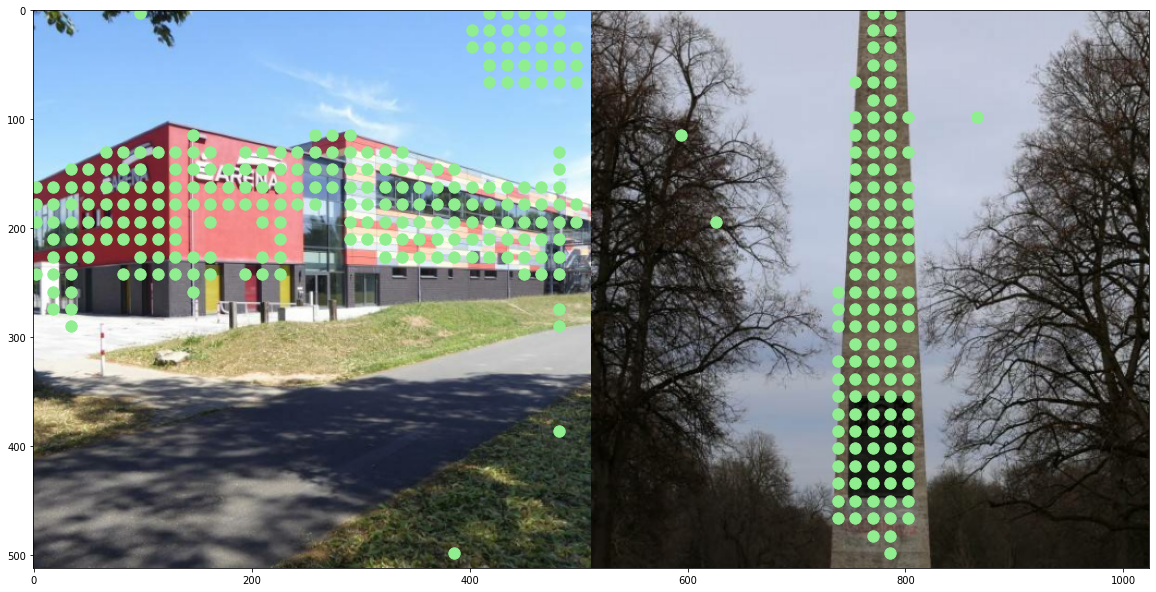

In [29]:

id1, id2 = 0, 1

image1, local_descriptor1, points1 = extract_local_descriptor(
    model=imported,
    path='../input/train',
    image_id=data.id[id1],
    reverse=False,
    dim=DIM,
    use_rf_boxes=True,
    attention_threshold=500,
    max_num_features=-1)

image2, local_descriptor2, points2 = extract_local_descriptor(
    model=imported,
    path='../input/train',
    image_id=data.id[id2],
    reverse=False,
    dim=DIM,
    use_rf_boxes=True,
    attention_threshold=500,
    max_num_features=-1)


x1_match, x2_match, mask, num = compute_num_inliers(
                    (local_descriptor1, points1), 
                    (local_descriptor2, points2),
                    max_reprojection_error=5.0,
                    homography_confidence=0.99,
                    max_ransac_iterations=100000)

#print(x1_match, x2_match)
# softmax prediction
image2b = imported.extract_image('../input/train', data.id[id2], 384, True, (0.7, 1.0))
prediction = imported.extract_global_prediction(image2b)

pred = tf.argmax(prediction).numpy()
print('pred  =', pred)
print('conf  =', tf.gather(prediction, pred).numpy())
#print('conf  =', tf.gather(prediction, train_df.label[id2]).numpy())
#print('label =', train_df.label[id2])
# until here


fig, ax = plt.subplots(1, 1, figsize=(20, 12))


image = np.concatenate([image1, image2], axis=1)

FOO = image.shape[1]

if isinstance(x1_match, int):
    x1_match = [None]
    x2_match = [None]

#score = min(num, len(points1)) / len(points1)
print('num points A =', len(points1), '; num matches A=', len(x1_match))
print('num points B =', len(points2), '; num matches B=', len(x2_match))
print("final matches =", num)
# print("final score =  ", score)

#score2 = num / ((len(points1) + len(points2))/ 2)

#print("new score   =  ", score2)
ax.imshow(image)

if num > 0:
    for m1, m2 in zip(x1_match[mask], x2_match[mask]):
        plt.plot([m1[1], m2[1]+DIM], [m1[0], m2[0]], '-o', c='red', alpha=0.75, linewidth=2, markersize=5)
        
        
ax.scatter(points1[:, 1], points1[:, 0], c='lightgreen', s=130)
ax.scatter(points2[:, 1]+DIM, points2[:, 0], c='lightgreen', s=130)

#for i in p:
#    plt.plot([i[0], i[2]], [i[1], i[3]], '-o', c='red', alpha=0.75, linewidth=2, markersize=5)
    

In [9]:
# # 3, 1
# pred  = 11421
# conf  = 0.14329177
# num points A = 28 ; num matches A= 15
# num points B = 43 ; num matches B= 15
# final matches = 7

# # 39 ,44 
# pred  = 69336
# conf  = 0.6247122
# num points A = 31 ; num matches A= 26
# num points B = 35 ; num matches B= 26
# final matches = 13